In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from factor_analyzer.rotator import Rotator
from concurrent.futures import ProcessPoolExecutor
import os

In [2]:
df_all = pd.read_csv('/Users/tanishq/PycharmProjects/NIScPR/FinTech/DerwentData_TS/ml/MainData.csv')
col = df_all['Application Date'].astype(str).str.strip().replace({'': pd.NA, 'nan': pd.NA})
dt = pd.to_datetime(col, format='mixed', dayfirst=True, errors='coerce')

df_all['Application Date'] = dt
df_all = df_all[(df_all['Application Date'] >= '2023-01-01') & (df_all['Application Date'] <= '2024-12-31')]

# df_ml = pd.read_csv('FinTech3OutputADA.csv')
df_ml = pd.read_csv('FinTech7OutputADA.csv')
df_ml = df_ml[df_ml['High Quality'] == 1]

df_sem = pd.read_csv('QualityIndex(23-24)_7.csv')
threshold = df_sem['Quality Index'].quantile(0.95)
df_sem = df_sem[df_sem['Quality Index'] > threshold]

In [3]:
df_sem.shape

(483, 20)

In [14]:
# df_ml = df_ml[df_ml['High Quality'] == 1]
df_ml

,Unnamed: 0,Publication Number,Application Date,Publication Date,IPC Subclass,Assignee Standardized,Claims Count,Assignee Count,Inventor Standardized,Publication Country Code,DWPI Count of Family Members,DWPI Count of Family Countries/Regions,Legal Years Remaining,IPC Count,Inventor Count,High Quality
32,32,IN202441087597A,2024-11-13,2024-11-22,G06Q | G06N,KIRUBADEVI M | MAGESWARAN G | DHARANIDHARAN M,6.0,3,KIRUBADEVI M | MAGESWARAN G | DHARANIDHARAN M,IN,1.0,1.0,19,1,3,1
63,63,IN202441077955A,2024-10-15,2024-10-25,G06F,CMR INSTITUTE OF TECHNOLOGY | CMR COLLEGE OF E...,10.0,3,KUMAR ANIL B | RENUKA K | BIRADAR KOMAL | PARA...,IN,1.0,1.0,19,1,8,1
124,124,IN202441071932A,2024-09-24,2024-10-04,H04L | G06Q | G06F,PRABHU ASHWIN G | SYLVIA GRACE J | NAIK YOGESW...,10.0,16,SYLVIA GRACE J | NAIK YOGESWAR B | KUMAR GANES...,IN,1.0,1.0,19,1,15,1
134,134,IN202441070726A,2024-09-18,2024-10-04,H04L | G06Q,SHANKAR CH | YOGI KOTTALA | SAHYAJA CH,6.0,3,SHANKAR CH | YOGI KOTTALA | SAHYAJA CH,IN,1.0,1.0,19,1,3,1
137,137,CN118796841B,2024-09-15,2024-11-22,G06F,BEIJING WANGZHI TIANYUAN BIG DATA TECHNOLOGY C...,10.0,2,ZHANG CHUAN WEN | MO QIAN | WANG KAI | HUANG G...,CN,2.0,1.0,19,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9806,29322,KR2025134177A,2023-01-11,2025-09-09,H04B | H04L,LG ELECTRONICS INC | KOREA ADVANCED INSTITUTE ...,10.0,2,JUNG JAEHOON | SEUNGWON KEUM | LEEJOOYOUNG | K...,KR,2.0,138.0,18,1,6,1
9808,29324,CN116055568B,2023-01-10,2025-09-12,H04L | G06F | G06N,CHINA CONSTRUCTION BANK CORPORATION | CCB FINT...,13.0,2,LIN JIA JUN | LIU WAN ZHEN | JIANG KUI DONG | ...,CN,2.0,1.0,18,1,5,1
9812,29328,KR2025133299A,2023-01-06,2025-09-05,H04W | H04L,LG ELECTRONICS INC | SEOUL NATIONAL UNIVERSITY...,15.0,3,LEE SANG LIM | HONGJEONGDAE | CHEON JUNG HEE |...,KR,2.0,138.0,18,1,4,1
9818,29334,KR2025128947A,2023-01-04,2025-08-28,H04B | H01Q | H04W,LG ELECTRONICS INC | KOREA ADVANCED INSTITUTE ...,22.0,2,JUNG JAEHOON | KIM DANG OH | CHOI WOO CHEOL | ...,KR,2.0,138.0,18,1,7,1


In [5]:
# cols_to_keep = [
#     'Publication Number', 'Publication Date', 'Earliest Priority Year',
#     'Publication Country Code', 'Assignee Standardized',
#     'Inventor Standardized', 'IPC Subclass', 'Count of Cited Refs - Patent',
#     'Count of Cited Refs - Non-patent', 'Count of Citing Patents',
#     'DWPI Count of Family Members', 'Assignee Count', 'Inventor Count',
#     'Claims Count', 'Legal Years Remaining', 'IPC Count',
#     'DWPI Count of Family Countries/Regions', 'Application Date'
# ]
#
# df1 = pd.DataFrame()
# df1['Publication Number'] = df_ml['Publication Number']
# # Perform the merge
# result = df1.merge(
#     df_all[cols_to_keep],
#     on='Publication Number',   # join key
#     how='left'                 # or 'inner' if you only want exact matches
# )
# result.to_csv('TopML_3Indicators.csv', index=False)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from collections import Counter

ipc_labels = {
    "H04W": "Wireless communication networks",
    "G06Q": "Data processing for admin/finance/commerce",
    "G06F": "Electric digital data processing (computers)",
    "H04L": "Transmission of digital information",
    "H04B": "Transmission (general)",
    "G06N": "Computer systems based on specific models (AI/NN etc.)",
    "G06V": "Image or video recognition / understanding",
    "G06K": "Recognition/presentation of data; record carriers",
    "G10L": "Speech analysis, synthesis, recognition",
    "H04N": "Pictorial communication (television, video)",
    "G06T": "Image data processing or generation (general)",
    "G01S": "Radio direction-finding, navigation, radar",
    "G07F": "Coin-freed/vending apparatus",
    "H04M": "Telephonic communication",
    "H04J": "Multiplex communication",
    "G08G": "Traffic control systems",
    "G16H": "Health informatics (ICT for healthcare)",
    "B60W": "Conjoint control of vehicle sub-units",
    "H03M": "Coding, decoding, or code conversion",
    "G07G": "Cash register / point-of-sale systems",
    "G07C": "Time/attendance; machine work logging; access/ID; fee/toll registers",
    "G01C": "Measuring distances, bearings; surveying; navigation; gyros; photogrammetry",
    "G05B": "Control or regulating systems in general; programmable/sequence controllers",
    "G07D": "Handling coins or paper currency; authenticity testing; cash/banknote processing",
    "G11B": "INFORMATION STORAGE BASED ON RELATIVE MOVEMENT BETWEEN RECORD CARRIER AND TRANSDUCER",
}

def plot_top_entities_combined(
    dfs: dict,
    column: str,
    k_per_record: int = 1,
    top_n: int = 20,
    wrap_width: int = 40,
    xlabel: str = "Number of Patents",
    ylabel: str = "Entity",
    title: str = "Top Entities Comparison",
    figsize=(14, 9),
    exclude=None,
    label_map=None,
    label_mode: str = "code+label",
    label_offset_frac: float = 0.04,   # 4% of bar width
    label_offset_min: float = 0.0      # at least this many units
):
    if not isinstance(dfs, dict) or len(dfs) == 0:
        raise ValueError("dfs must be a non-empty dict of name->DataFrame.")
    for name, df in dfs.items():
        if column not in df.columns:
            raise KeyError(f"Column '{column}' not in DataFrame '{name}'.")

    def top_k(entry: str) -> str:
        if not isinstance(entry, str):
            return ""
        parts = [x.strip() for x in entry.split(",") if x.strip()]
        return " | ".join(parts[:k_per_record]) if k_per_record > 0 else ""

    def wrap_labels(label: str) -> str:
        return "\n".join(textwrap.wrap(str(label), wrap_width)) if label else ""

    ex = set(exclude or set())

    # row-normalized counts
    count_dfs = []
    for name, df in dfs.items():
        df_tmp = df.copy()
        df_tmp[column + "_top"] = df_tmp[column].apply(top_k)

        counts = Counter()
        for entry in df_tmp[column + "_top"]:
            if isinstance(entry, str) and entry.strip():
                ents = {
                    ent.strip() for ent in entry.split("|")
                    if ent.strip() and ent.strip() not in ex
                }
                if ents:
                    w = 1.0 / len(ents)
                    for key in ents:
                        counts[key] += w

        count_df = pd.DataFrame(counts.items(), columns=[column, name])
        count_dfs.append(count_df)

    # merge and rank
    merged_counts = count_dfs[0]
    for df_ in count_dfs[1:]:
        merged_counts = pd.merge(merged_counts, df_, on=column, how="outer")
    merged_counts = merged_counts.fillna(0)

    value_cols = [c for c in merged_counts.columns if c != column]
    merged_counts["Total"] = merged_counts[value_cols].sum(axis=1)
    merged_counts = merged_counts.sort_values("Total", ascending=False).head(top_n).copy()

    # labels
    if label_map:
        def build_label(code: str) -> str:
            desc = label_map.get(code)
            return code if not desc else (desc if label_mode == "replace" else f"{code} – {desc}")
        merged_counts["label"] = merged_counts[column].map(build_label)
    else:
        merged_counts["label"] = merged_counts[column]
    merged_counts["wrapped"] = merged_counts["label"].apply(wrap_labels)

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    y = range(len(merged_counts))
    n_series = max(1, len(dfs))
    height = 0.8 / n_series

    palette = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3","C4","C5"])
    colors = (palette * ((n_series // len(palette)) + 1))[:n_series]

    # global max to set xlim and compute a safe outer margin
    global_max = 0.0
    for name in dfs.keys():
        if name in merged_counts:
            global_max = max(global_max, float(merged_counts[name].max() or 0.0))
    xmax = global_max * 1.12 if global_max > 0 else 1.0
    ax.set_xlim(0, xmax)

    for i, (name, color) in enumerate(zip(list(dfs.keys()), colors)):
        vals = merged_counts[name].values if name in merged_counts else [0]*len(merged_counts)
        bars = ax.barh(
            [pos + i * height for pos in y],
            vals,
            height=height,
            label=name,
            color=color,
        )
        for bar in bars:
            w = bar.get_width()
            if w > 0:
                # adaptive label offset
                offset = max(label_offset_frac * w, label_offset_min)
                x_text = min(w + offset, xmax * 0.995)  # keep inside axes
                ax.text(
                    x_text,
                    bar.get_y() + bar.get_height() / 2,
                    f"{w:.2f}",
                    va="center",
                    ha="right" if x_text >= xmax * 0.99 else "left",
                    fontsize=8,
                )

    mid_offset = (n_series - 1) * height / 2
    ax.set_yticks([pos + mid_offset for pos in y], merged_counts["wrapped"], fontsize=8)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.invert_yaxis()
    plt.xscale("symlog", linthresh=10)
    fig.tight_layout()
    plt.show()

    return merged_counts

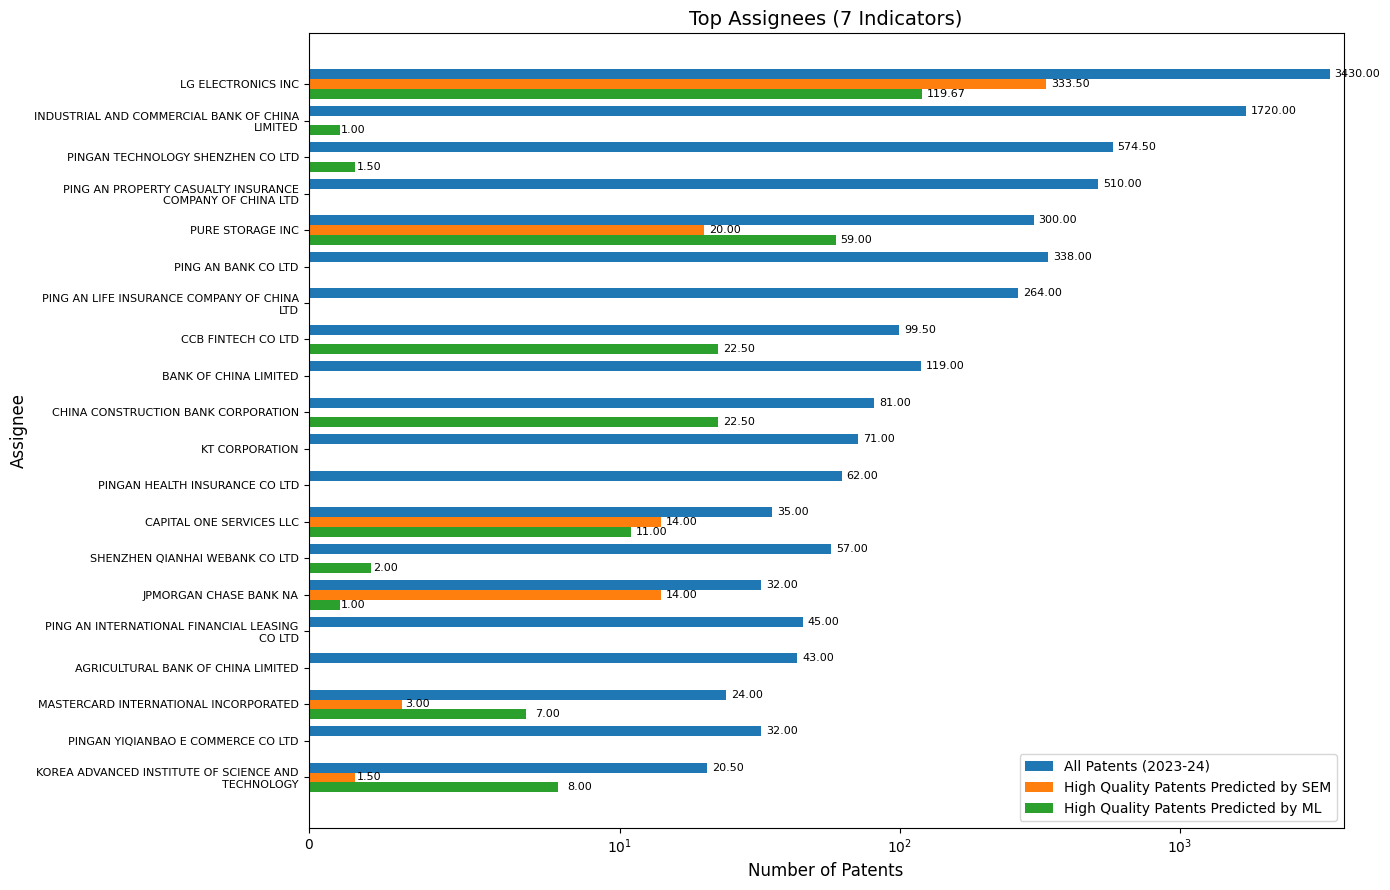

,Assignee Standardized,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
844,LG ELECTRONICS INC,3430.0,333.5,119.666667,3883.166667,LG ELECTRONICS INC,LG ELECTRONICS INC
605,INDUSTRIAL AND COMMERCIAL BANK OF CHINA LIMITED,1720.0,0.0,1.000000,1721.000000,INDUSTRIAL AND COMMERCIAL BANK OF CHINA LIMITED,INDUSTRIAL AND COMMERCIAL BANK OF CHINA\nLIMITED
1110,PINGAN TECHNOLOGY SHENZHEN CO LTD,574.5,0.0,1.500000,576.000000,PINGAN TECHNOLOGY SHENZHEN CO LTD,PINGAN TECHNOLOGY SHENZHEN CO LTD
1103,PING AN PROPERTY CASUALTY INSURANCE COMPANY OF...,510.0,0.0,0.000000,510.000000,PING AN PROPERTY CASUALTY INSURANCE COMPANY OF...,PING AN PROPERTY CASUALTY INSURANCE\nCOMPANY O...
1155,PURE STORAGE INC,300.0,20.0,59.000000,379.000000,PURE STORAGE INC,PURE STORAGE INC
1099,PING AN BANK CO LTD,338.0,0.0,0.000000,338.000000,PING AN BANK CO LTD,PING AN BANK CO LTD
1102,PING AN LIFE INSURANCE COMPANY OF CHINA LTD,264.0,0.0,0.000000,264.000000,PING AN LIFE INSURANCE COMPANY OF CHINA LTD,PING AN LIFE INSURANCE COMPANY OF CHINA\nLTD
235,CCB FINTECH CO LTD,99.5,0.0,22.500000,122.000000,CCB FINTECH CO LTD,CCB FINTECH CO LTD
116,BANK OF CHINA LIMITED,119.0,0.0,0.000000,119.000000,BANK OF CHINA LIMITED,BANK OF CHINA LIMITED
271,CHINA CONSTRUCTION BANK CORPORATION,81.0,0.0,22.500000,103.500000,CHINA CONSTRUCTION BANK CORPORATION,CHINA CONSTRUCTION BANK CORPORATION


In [7]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="Assignee Standardized",
    ylabel="Assignee",
    title="Top Assignees (7 Indicators)",
    k_per_record=1,
    top_n=20
)

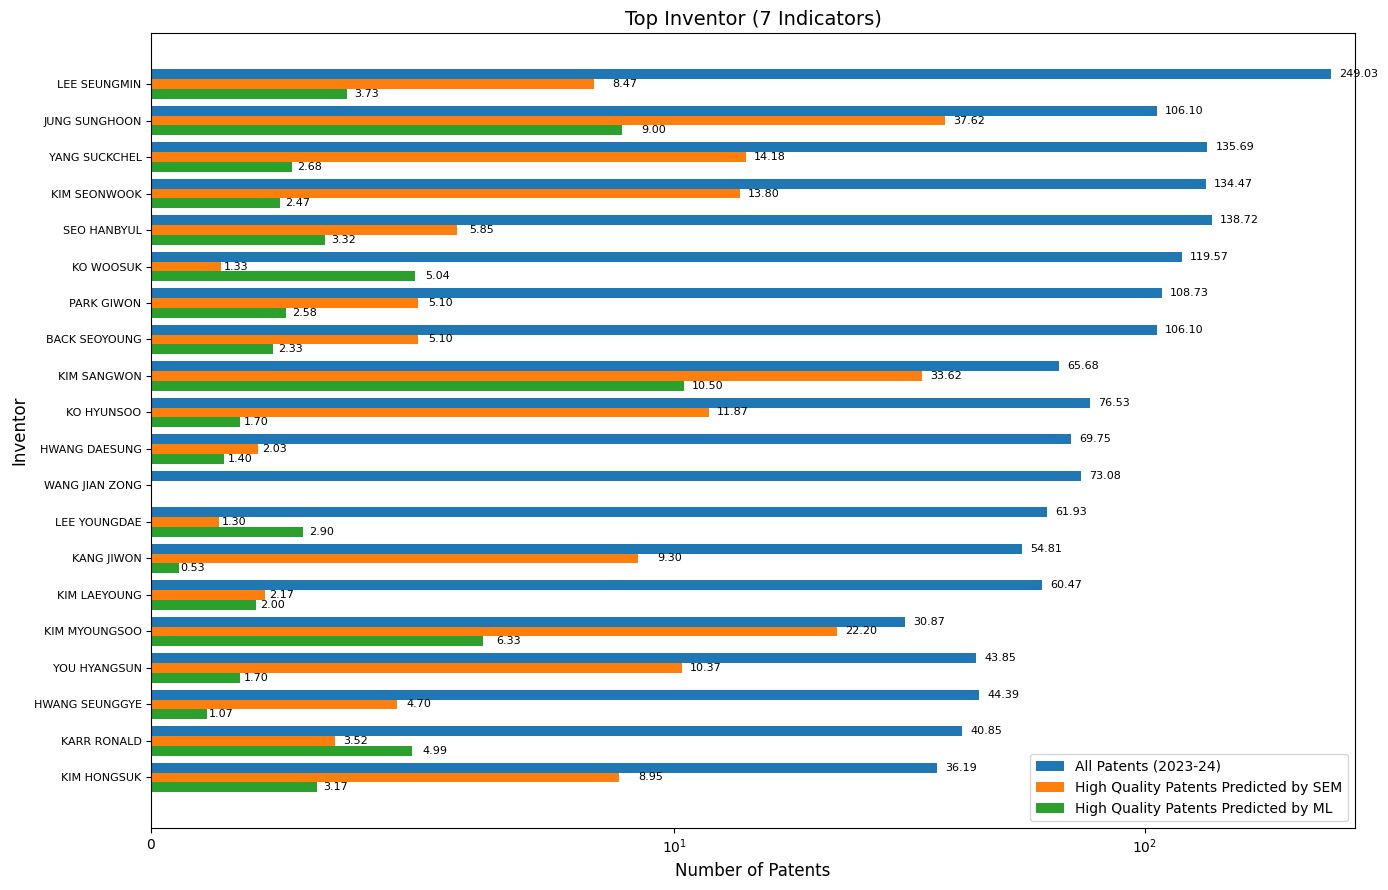

,Inventor Standardized,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
3483,LEE SEUNGMIN,249.028571,8.466667,3.733333,261.228571,LEE SEUNGMIN,LEE SEUNGMIN
2923,JUNG SUNGHOON,106.100000,37.616667,9.000000,152.716667,JUNG SUNGHOON,JUNG SUNGHOON
8224,YANG SUCKCHEL,135.688095,14.183333,2.683333,152.554762,YANG SUCKCHEL,YANG SUCKCHEL
3164,KIM SEONWOOK,134.466667,13.800000,2.466667,150.733333,KIM SEONWOOK,KIM SEONWOOK
6001,SEO HANBYUL,138.716667,5.850000,3.316667,147.883333,SEO HANBYUL,SEO HANBYUL
3242,KO WOOSUK,119.567857,1.333333,5.042857,125.944048,KO WOOSUK,KO WOOSUK
5339,PARK GIWON,108.733333,5.100000,2.583333,116.416667,PARK GIWON,PARK GIWON
153,BACK SEOYOUNG,106.100000,5.100000,2.333333,113.533333,BACK SEOYOUNG,BACK SEOYOUNG
3154,KIM SANGWON,65.683333,33.616667,10.500000,109.800000,KIM SANGWON,KIM SANGWON
3240,KO HYUNSOO,76.533333,11.866667,1.700000,90.100000,KO HYUNSOO,KO HYUNSOO


In [8]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="Inventor Standardized",
    ylabel="Inventor",
    title="Top Inventor (7 Indicators)",
    k_per_record=1,
    top_n=20
)

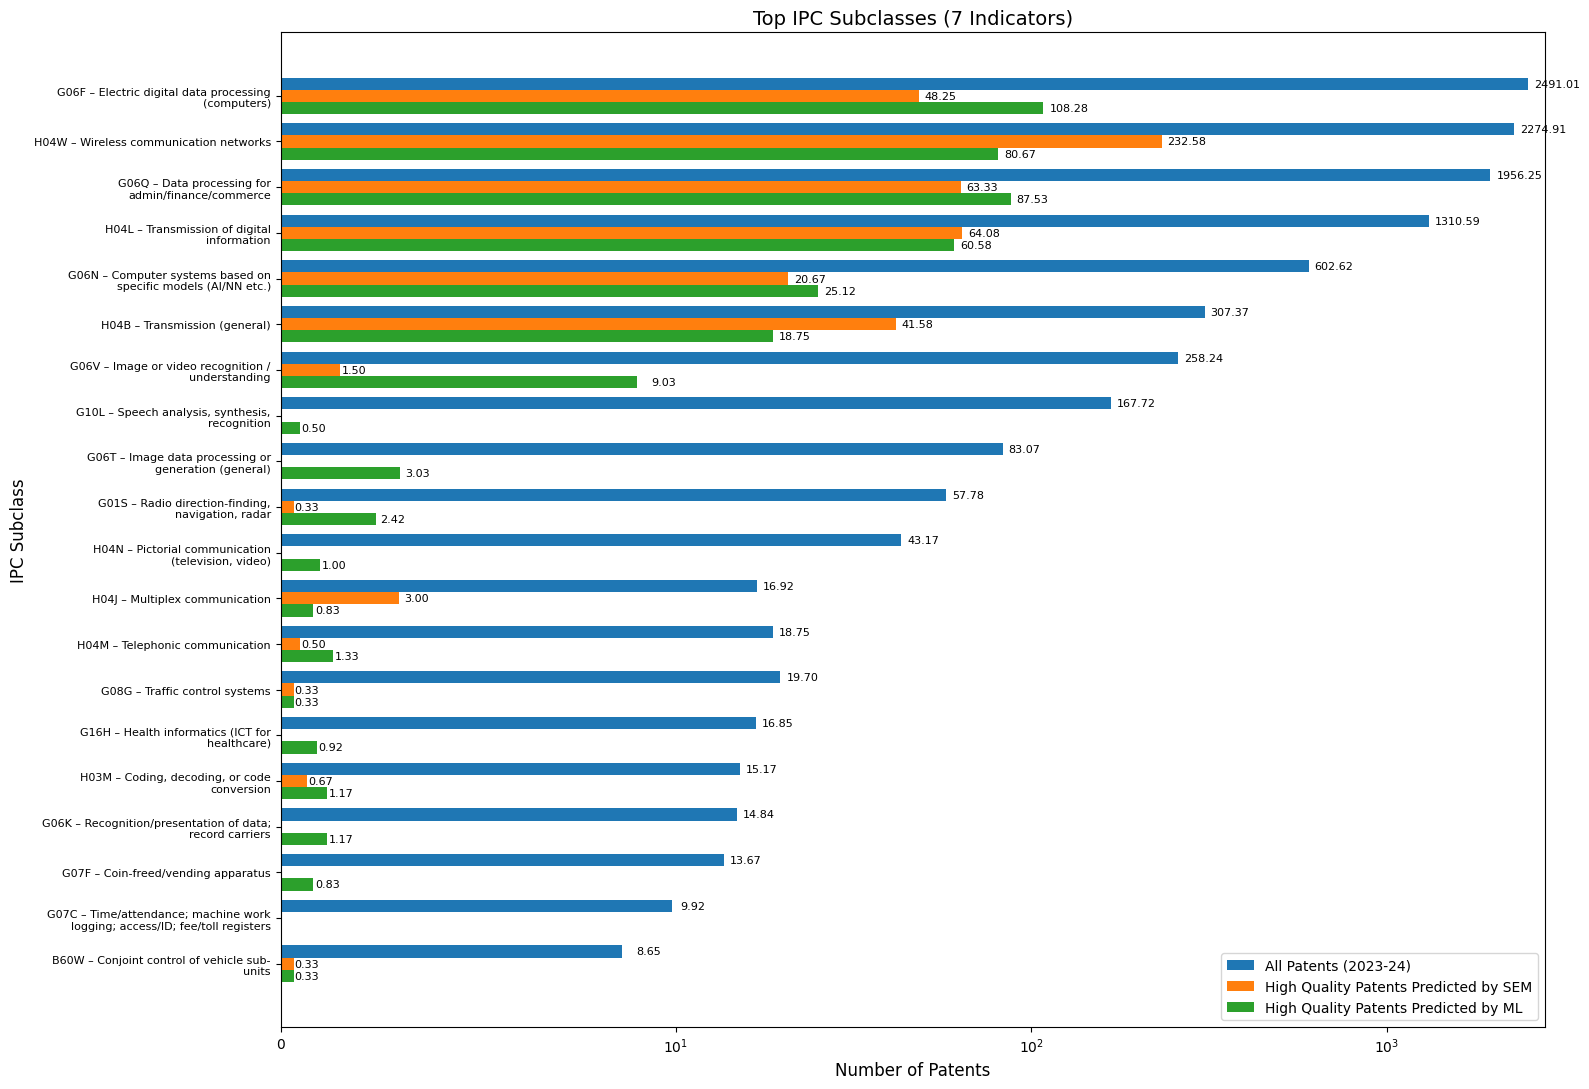

,IPC Subclass,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
80,G06F,2491.009524,48.250000,108.283333,2647.542857,G06F – Electric digital data processing (compu...,G06F – Electric digital data processing\n(comp...
122,H04W,2274.909524,232.583333,80.666667,2588.159524,H04W – Wireless communication networks,H04W – Wireless communication networks
84,G06Q,1956.252381,63.333333,87.533333,2107.119048,G06Q – Data processing for admin/finance/commerce,G06Q – Data processing for\nadmin/finance/comm...
117,H04L,1310.592857,64.083333,60.583333,1435.259524,H04L – Transmission of digital information,H04L – Transmission of digital\ninformation
83,G06N,602.616667,20.666667,25.116667,648.400000,G06N – Computer systems based on specific mode...,G06N – Computer systems based on\nspecific mod...
114,H04B,307.366667,41.583333,18.750000,367.700000,H04B – Transmission (general),H04B – Transmission (general)
86,G06V,258.242857,1.500000,9.033333,268.776190,G06V – Image or video recognition / understanding,G06V – Image or video recognition /\nunderstan...
99,G10L,167.716667,0.000000,0.500000,168.216667,"G10L – Speech analysis, synthesis, recognition","G10L – Speech analysis, synthesis,\nrecognition"
85,G06T,83.066667,0.000000,3.033333,86.100000,G06T – Image data processing or generation (ge...,G06T – Image data processing or\ngeneration (g...
72,G01S,57.783333,0.333333,2.416667,60.533333,"G01S – Radio direction-finding, navigation, radar","G01S – Radio direction-finding,\nnavigation, r..."


In [9]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="IPC Subclass",
    k_per_record=1,
    title="Top IPC Subclasses (7 Indicators)",
    ylabel="IPC Subclass",
    label_map=ipc_labels,
    label_mode="code+label",
    figsize=(16, 11)

)

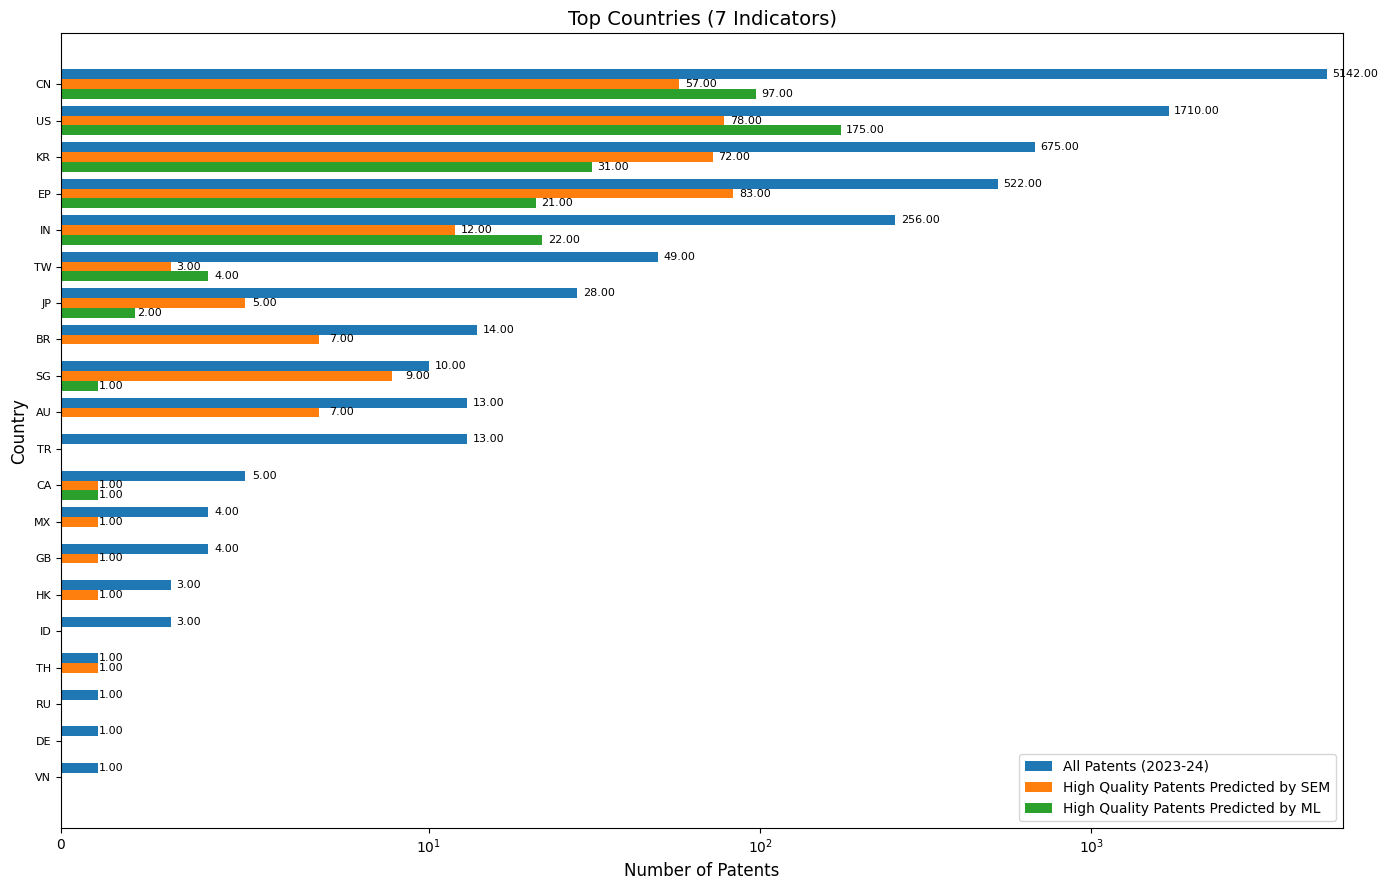

,Publication Country Code,All Patents (2023-24),High Quality Patents Predicted by SEM,High Quality Patents Predicted by ML,Total,label,wrapped
3,CN,5142.0,57.0,97.0,5296.0,CN,CN
18,US,1710.0,78.0,175.0,1963.0,US,US
11,KR,675.0,72.0,31.0,778.0,KR,KR
5,EP,522.0,83.0,21.0,626.0,EP,EP
9,IN,256.0,12.0,22.0,290.0,IN,IN
17,TW,49.0,3.0,4.0,56.0,TW,TW
10,JP,28.0,5.0,2.0,35.0,JP,JP
1,BR,14.0,7.0,0.0,21.0,BR,BR
14,SG,10.0,9.0,1.0,20.0,SG,SG
0,AU,13.0,7.0,0.0,20.0,AU,AU


In [10]:
plot_top_entities_combined(
    dfs={"All Patents (2023-24)": df_all, "High Quality Patents Predicted by SEM": df_sem, "High Quality Patents Predicted by ML": df_ml},
    column="Publication Country Code",
    k_per_record=1,
    title="Top Countries (7 Indicators)",
    ylabel="Country",
    exclude={"WO"}                 # <- ignore WO
)

In [11]:
common_df = df_sem[df_sem["Publication Number"].isin(df_ml["Publication Number"])]


In [12]:
common_df.shape

(71, 20)

In [13]:
common_df.to_csv('Common_3.csv', index=False)